In [1]:
pip install jax==0.3.13 https://whls.blob.core.windows.net/unstable/cuda111/jaxlib-0.3.7+cuda11.cudnn82-cp38-none-win_amd64.whl


ERROR: jaxlib-0.3.7+cuda11.cudnn82-cp38-none-win_amd64.whl is not a supported wheel on this platform.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
import json
from ast import literal_eval
from pylab import *
from scipy.signal import argrelextrema
import pandas as pd
import glob
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True 
import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem


def dipole_moment_plot(smiles, method):
    # Correction of smiles for triple bonds
    smiles_xTB = smiles.replace("#","%23")
    
    #Request the calcualtion in xTB service
    r          = requests.get('https://ir.cheminfo.org/v1/ir?smiles={0}&method={1}'.format(smiles_xTB, method))
    data_bytes = r.content
    data_dic   = json.loads(data_bytes.decode('utf-8'))


    wavenumb   = array(data_dic["wavenumbers"])
    
    # Import normal modes
    modes = data_dic["modes"]
    vib_modes=[]
    for i in range(0,len(modes)):
        if modes[i]['modeType']=='vibration':
            vib_modes.append(modes[i])
            
    # Import frequencies
    frequency=[]
    for i in range(0,len(vib_modes)):
        frequency.append(vib_modes[i]["wavenumber"])
        
    # Import normal modes coordinates
    a        = vib_modes[0]["displacements"]
    ar_s     = a.split("\n")
    modes_al = ar_s[2:-1]

    modes_al_c = []
    for i in modes_al:
        modes_al_c.append((" ".join(i.split())).split())

    print("There are {0} normal modes".format(len(vib_modes)))
   
    elements = []
    for i in modes_al_c:
        elements.append(i[0])
            
    print(elements)  
    # Define the function to calculate the dipole moment for a configuration
    def calculate_dipole_moment(coordinates, charges, masses):
        # Calculate the center of mass
        total_mass = jnp.sum(masses)
        center_of_mass = jnp.sum(coordinates * masses[:, None], axis=0) / total_mass

        # Calculate the dipole moment
        dipole_moment = jnp.zeros(3)

        for charge, (x, y, z) in zip(charges, coordinates):
            dipole_moment += charge * jnp.array([x, y, z]) - charge * center_of_mass

        return dipole_moment

    # Define the function for linear interpolation of configurations
    def interpolate_configurations(initial_coords, final_coords, num_steps):
        steps = jnp.linspace(0.0, 1.0, num_steps)[:, None, None]
        return initial_coords + steps * (final_coords - initial_coords)


    def calculate_partial_charges(molecule_smiles):
        # Create an RDKit molecule object
        mol = Chem.MolFromSmiles(molecule_smiles)

        # Add hydrogens and generate 3D coordinates
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())

        # Compute Gasteiger partial charges
        AllChem.ComputeGasteigerCharges(mol)

        # Get the computed partial charges for each atom
        partial_charges = [atom.GetDoubleProp("_GasteigerCharge") for atom in mol.GetAtoms()]
        atom_masses = []
        for atom in mol.GetAtoms():
            atom_mass = atom.GetMass()
            atom_masses.append(atom_mass)

        return partial_charges, atom_masses

    partial_charges, atom_masses = calculate_partial_charges(smiles)
    
    charges = jnp.array(partial_charges)
    masses  = jnp.array(atom_masses)
    
    print("Tha charges are {0} with a mass of {1}".format(charges, masses))

    ########## ---------- Writing the initial positions --------- 
    μ_all= []
    for mode in range(0,len(vib_modes)):
        μ_i_f = []
        a        = vib_modes[mode]["displacements"]
        ar_s     = a.split("\n")
        modes_al = ar_s[2:-1]

        modes_al_c = []
        for i in modes_al:
            modes_al_c.append((" ".join(i.split())).split())

        num_modes = []
        elements = []
        for i in modes_al_c:
            atom      = []
            for k in range(1,4):
                atom.append(float(i[k])) 
            elements.append(i[0])
            num_modes.append(atom)

        coordinates = []
        for i in num_modes:
            coordinates.append(tuple(i))
        initial_coordinates = jnp.array(num_modes)
#         print(initial_coordiantes)
        

        #### Final positions  
        vib_modes_1 = []

        for i in modes_al_c:
            atom      = []
            for k in range(4,7):
                atom.append(float(i[k])) 
            vib_modes_1.append(atom)

        coordinates_vib = []
        for i in vib_modes_1:
            coordinates_vib.append(tuple(i))
        final_coordinates = jnp.array(vib_modes_1)
#         print(final_coordinates)

        # Compute 100 intermediate configurations using linear interpolation for each coordinate
        num_interpolations = 100
        interpolated_coordinates = interpolate_configurations((initial_coordinates)[None, :], (initial_coordinates+final_coordinates)[None, :], num_interpolations)

        # Calculate the dipole moment magnitudes for each configuration
        dipole_moment_magnitudes = vmap(calculate_dipole_moment, (0, None, None))(interpolated_coordinates, charges, masses)

        # Print the list of dipole moment magnitudes
        # print(dipole_moment_magnitudes)
        news=[]
        for i in dipole_moment_magnitudes:
            news.append(float(jnp.linalg.norm(i)))
        
        plot(news, label=r"$\nu= {0} \ cm-1$".format(round(frequency[mode],2) ))
        ylim(-0.01)
        
        legend()
        μ_all.append(news)
        
    return μ_all,frequency
    
        

There are 4 normal modes
['O', 'C', 'O']
Tha charges are [-0.18646441  0.37292883 -0.18646441] with a mass of [15.999 12.011 15.999]


100

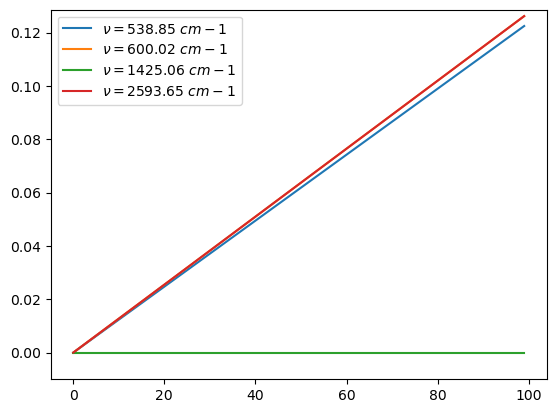

In [10]:
a,dipoles_f=dipole_moment_plot("O=C=O", "GFN2xTB")
len(a[0])

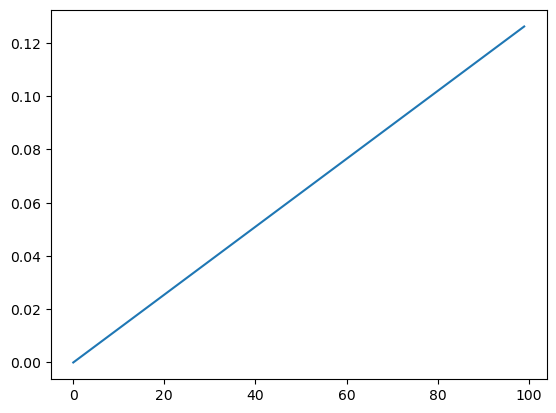

In [11]:
plot(sort(a[1]))

In [68]:
for i,k in zip(a,dipoles_f):
    b=linalg.norm(gradient(i))
    print("At frequency: ",round(k,2) , "the gradient is: ", b)
    

At frequency:  1385.56 the gradient is:  0.00368113864575901
At frequency:  1385.64 the gradient is:  0.0036810848056543794
At frequency:  1385.81 the gradient is:  0.003680979123729034
At frequency:  1557.07 the gradient is:  3.3195411070627455e-06
At frequency:  1557.26 the gradient is:  1.7263930331113392e-06
At frequency:  3090.4 the gradient is:  4.399445757760931e-05
At frequency:  3104.06 the gradient is:  0.002604043270445535
At frequency:  3104.27 the gradient is:  0.002603844414257275
At frequency:  3104.57 the gradient is:  0.0026037823788724215


In [63]:
dipoles_f

[1385.5566382490101,
 1385.6379675889434,
 1385.8142669200954,
 1557.0720125351288,
 1557.2577898244222,
 3090.403719172943,
 3104.0599481213467,
 3104.2663801977355,
 3104.5681748616003]

In [48]:
list(a[0])

[0.23416703939437866,
 0.23436009883880615,
 0.23455312848091125,
 0.23474615812301636,
 0.23493918776512146,
 0.23513224720954895,
 0.23532529175281525,
 0.23551830649375916,
 0.23571136593818665,
 0.23590439558029175,
 0.23609744012355804,
 0.23629048466682434,
 0.23648351430892944,
 0.23667654395103455,
 0.23686958849430084,
 0.23706264793872833,
 0.23725569248199463,
 0.23744872212409973,
 0.23764175176620483,
 0.23783479630947113,
 0.23802784085273743,
 0.23822087049484253,
 0.23841391503810883,
 0.23860694468021393,
 0.23879998922348022,
 0.23899303376674652,
 0.23918607831001282,
 0.23937910795211792,
 0.23957213759422302,
 0.2397651970386505,
 0.23995821177959442,
 0.24015125632286072,
 0.2403443157672882,
 0.2405373454093933,
 0.2407303899526596,
 0.2409234195947647,
 0.2411164790391922,
 0.2413095086812973,
 0.2415025532245636,
 0.2416955977678299,
 0.241888627409935,
 0.2420816719532013,
 0.2422747164964676,
 0.2424677461385727,
 0.242660790681839,
 0.24285383522510529,
 0.2